In [1]:
import numpy as np
from numba import jit
import time
from scipy.interpolate import interp1d

G=1
c=1
M01 = 1.474 * 10**3

G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)                  ############ m / s

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4


from numba import jit
@jit(nopython = True)
def love_number(C,y):
  k2 = 8 / 5 * C ** 5 * (1 - 2 * C) **(2) * (2 + 2 * C * (y - 1) - y) * (2 * C * (6 - 3 * y + 3 * C * (5 * y - 8)) + 4 * C ** 3 * (13 - 11 * y + C * (3 * y - 2) + 2 * C ** 2 * (1 + y)) + 3 * (1 - 2 * C) ** 2 * (2 - y + 2 * C * (y - 1)) * (np.log(1 - 2 * C))) ** (-1)
  return k2


@jit(nopython = True)
def beta_and_H(r, p, H, m, beta, parr, earr):
    dp = p * 0.005

    el_3 = en_dens(parr, earr, p - 3 * dp)
    el_2 = en_dens(parr, earr, p - 2 * dp)
    el_1 = en_dens(parr, earr, p - 1 * dp)
    er_3 = en_dens(parr, earr, p + 3 * dp)
    er_2 = en_dens(parr, earr, p + 2 * dp)
    er_1 = en_dens(parr, earr, p + 1 * dp)

    de_dp = (-1 / 60 * el_3 + 3 / 20 * el_2 - 3 / 4 * el_1 + 3 / 4 * er_1 - 3 / 20 * er_2 + 1 / 60 * er_3) / dp

    #G = 6.67430e-11  # Gravitational constant
    #c = 299792458.0  # Speed of light
    G = 1
    c = 1

    e = en_dens(parr, earr, p)
    dbeta_dr = 2 * (1 - 2 * m / r ) ** (-1) *H * (-2 * np.pi * G / c ** 2 * (5 * e + 9 * p / c ** 2 + de_dp * c ** 2 * (e + p / c ** 2)) + 3 / r ** 2 + 2 * (1 - 2 * m / r ) ** (-1) * ( m / r ** 2 + G / c ** 4 * 4 * np.pi * r * p) ** 2) + 2 * (1 - 2 * m / r ) ** (-1) *beta / r * (-1 + m / r + 2 * np.pi * r ** 2 * G / c ** 2 * (e - p / c ** 2))

    dHdr = beta
    return dbeta_dr, dHdr

@jit(nopython=True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e

@jit(nopython = True)
def find_ind(arr, val):
    for i, item in enumerate(arr):
        if val > item:
            continue
        else:
            return i
    return len(arr)

class PressureOutOfRangeError(Exception):
    pass

@jit(nopython = True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e


@jit(nopython = True)
def ene_interp(pre_arr, ene_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        ene_val = (pressure - left_p)*(right_e - left_e)/(right_p - left_p) + left_e
    return ene_val

@jit(nopython = True)
def pre_interp(pre_arr, ene_arr, energy):
    if energy < min(ene_arr) or energy > max(ene_arr):
        raise PressureOutOfRangeError("Energy is out of range.")
    else:
        ind = find_ind(ene_arr, energy)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        pre_val = (energy - left_e)*(right_p - left_p)/(right_e - left_e) + left_p
    return pre_val

def cs2_interp(cs2_arr, pre_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_c = cs2_arr[ind - 1]
        right_c = cs2_arr[ind]
        left_p = pre_arr[ind-1]
        right_p = pre_arr[ind]
        cs2_val = (pressure - left_p)*(right_c - left_c)/(right_p - left_p) + left_c
    return cs2_val

@jit(nopython = True)
def Tov_eqn(P, r, m, dens, press, G, c, min_pressure):
    if P < min_pressure:
        return 0.0
    else:
        eden = ene_interp(press, dens, P)
        return -(G * ((P / c ** 2) + eden) * (m + 4 * np.pi * r ** 3 * P / c ** 2)) / (r * (r - 2 * G * m / c ** 2))

@jit(nopython = True)
def mass_eqn(r, ene):
    return 4 * np.pi * r ** 2 * ene


def TOV_module(cen_dens, pressure, density, exit_Pre,love=False, to_print=False):
    asi = 0
    P_exit =exit_Pre
    for i in range(len(cen_dens)):
        press = np.array(pressure)
        dens = np.array(density)
        d = cen_dens[i]
        P0 = pre_interp(press, dens, d)
        r = 10
        P = P0
        m = mass_eqn(r,d)
        h = 1
        a0 = 1
        H0 = a0*r**2
        beta0 = 2*a0*r
        min_pressure = min(press)
        beta = beta0
        H = H0
        if  love == True:
            #print("Entering Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                k1_dbeta_dr, k1_dHdr = beta_and_H(r, P, H, m, beta, press, dens)
                k2_dbeta_dr, k2_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k1_p, H + 0.5 * h * k1_dHdr, m + 0.5*h*k1_m, beta + 0.5*h*k1_dbeta_dr, press, dens)
                k3_dbeta_dr, k3_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k2_p, H + 0.5 * h * k2_dHdr, m + 0.5*h*k2_m, beta + 0.5*h*k2_dbeta_dr, press, dens)
                k4_dbeta_dr, k4_dHdr = beta_and_H(r + h, P + h * k3_p, H + h * k3_dHdr, m + h*k3_m, beta + h*k3_dbeta_dr, press, dens)

                beta = beta + (h / 6.0) * (k1_dbeta_dr + 2 * k2_dbeta_dr + 2 * k3_dbeta_dr + k4_dbeta_dr)
                H = H + (h / 6.0) * (k1_dHdr + 2 * k2_dHdr + 2 * k3_dHdr + k4_dHdr)
                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            y = r * beta/ (H)
            C = m/(r)
            k2 = love_number(C,y)
            Com.append(C)
            Love.append(k2)
            if to_print == True:
                print("star ", i," done")
        else:
            #print("Entering No Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            if to_print == True:
                print("star ", i," done")
    return R,M,Com,Love

In [3]:

import numpy as np
import matplotlib.pyplot as plt


#data1 = np.loadtxt('./EOS-Data/Had_EOS_13.dat')
# file = './EOS-Data/Had_EoS1'
# for i in range(0,10000):
#     data1 = np.loadtxt('./EOS-Data/Had_EoS1/Had_EOS_'+str(i)+'.dat')
#     plt.plot(data1[:,1], data1[:,0], label='Had_EOS_'+str(i))
data1 = np.loadtxt('EOS-Data/Had_EoS1/Had_EOS_15.dat', delimiter=' ',skiprows=1)

In [4]:
G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)  

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4

density_dat = data1[:, 1]
pressure_dat = data1[:, 0]

# sound_speed_dat = data1[:,2]

density_dat_GU = density_dat*Mev_fm3_to_GU
pressure_dat_GU = pressure_dat*Mev_fm3_to_GU

# density_dat_GU.astype(np.float64)
# pressure_dat_GU.astype(np.float64)

print(np.max(density_dat_GU), np.max(pressure_dat_GU))
print(np.min(density_dat_GU), np.min(pressure_dat_GU))

# print(density_dat_GU)



3.5135225724810287e-09 1.7684558180779237e-09
5.777372839506173e-24 8.304397037037036e-37


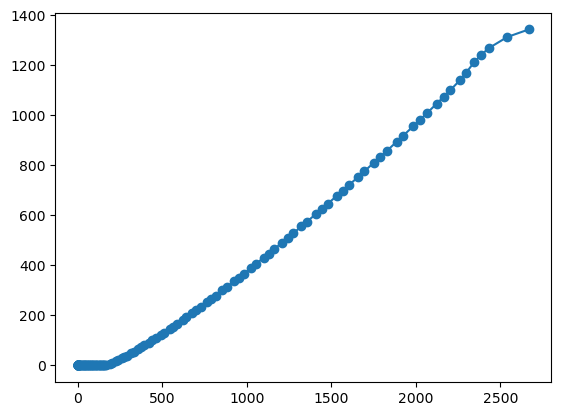

In [5]:
plt.plot(density_dat, pressure_dat, label='EOS')
plt.scatter(density_dat, pressure_dat, label='EOS')

In [6]:
central_energy = np.logspace(np.log10(np.max(density_dat_GU)*0.999),np.log10( 2.072392843084521e-10),50)
#central_energy = np.asarray(central_energy[1])
print(np.max(central_energy), np.min(central_energy),central_energy[7])

3.510009049908541e-09 2.072392843084521e-10 2.342934861358921e-09


In [7]:
M= []
R = []
Com = []
Love = []

In [8]:
R,M,Com,Love = TOV_module(central_energy, pressure_dat_GU,density_dat_GU,exit_Pre=np.min(1.1*pressure_dat_GU),love=True,to_print=True)

star  0  done
star  1  done
star  2  done
star  3  done
star  4  done
star  5  done
star  6  done
star  7  done
star  8  done
star  9  done
star  10  done
star  11  done
star  12  done
star  13  done
star  14  done
star  15  done
star  16  done
star  17  done
star  18  done
star  19  done
star  20  done
star  21  done
star  22  done
star  23  done
star  24  done
star  25  done
star  26  done
star  27  done
star  28  done
star  29  done
star  30  done
star  31  done
star  32  done
star  33  done
star  34  done
star  35  done
star  36  done
star  37  done
star  38  done
star  39  done
star  40  done
star  41  done
star  42  done
star  43  done
star  44  done
star  45  done
star  46  done
star  47  done
star  48  done
star  49  done


Text(0, 0.5, 'M/Msun')

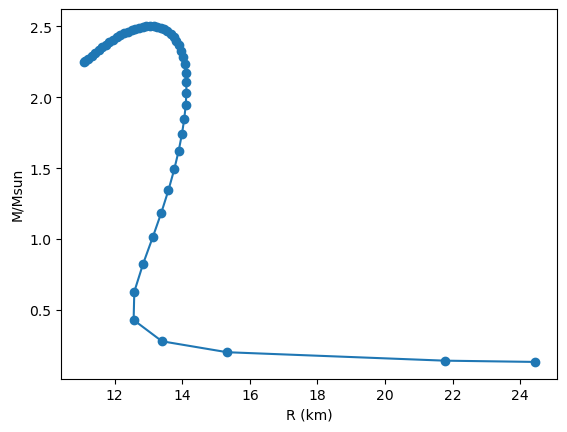

In [9]:
plt.plot(R,M, label='TOV')
plt.scatter(R,M, label='TOV')
plt.xlabel('R (km)')
plt.ylabel('M/Msun')
# plt.xlim(0,20)

In [10]:
max(M)

2.5029512849511155

In [11]:
## Tidal Deformability Calculation

def Lambda(k2, C):
    return (2/3)*k2*C**(-5.0)



In [12]:
## For 1.36M and q = 0.73



m1 = np.linspace(1.36,1.60,10)
# q = np.asarray([0.73,0.80,0.87,0.95])
m2 = np.linspace(1.16,1.36,10)

print(m2)
print(m1)

radius_from_mass = interp1d(M,R,fill_value='extrapolate')

r1 = radius_from_mass(m1)
r2 = radius_from_mass(m2)

print(r2)

love_from_mass = interp1d(M,Love,fill_value='extrapolate')
Compactness_from_mass = interp1d(M,Com,fill_value='extrapolate')

love1 = love_from_mass(m1)
love2 = love_from_mass(m2)

C1 = Compactness_from_mass(m1)
C2 = Compactness_from_mass(m2)

print(love2)

print(C1, C2)

print('M_TOV = ',np.max(M))
print('R_1.6 = ', radius_from_mass(1.6))

[1.16       1.18222222 1.20444444 1.22666667 1.24888889 1.27111111
 1.29333333 1.31555556 1.33777778 1.36      ]
[1.36       1.38666667 1.41333333 1.44       1.46666667 1.49333333
 1.52       1.54666667 1.57333333 1.6       ]
[13.34478776 13.37737466 13.40748238 13.43695741 13.46643244 13.49590748
 13.52538251 13.55485754 13.58433257 13.61156316]
[0.12754361 0.1271266  0.12635612 0.12549542 0.12463473 0.12377404
 0.12291335 0.12205266 0.12119196 0.12015253]
[0.14725965 0.149785   0.15231035 0.15483571 0.15736106 0.15988618
 0.16240844 0.16493069 0.16745294 0.16997519] [0.1280855  0.13025616 0.13239126 0.13451728 0.1366433  0.13876932
 0.14089534 0.14302136 0.14514738 0.14725965]
M_TOV =  2.5029512849511155
R_1.6 =  13.873548184618183


In [13]:
lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

print(lam1)
print(lam2)

[1156.70584061 1050.32449345  954.9567633   869.32449643  792.31412683
  722.85618776  659.08690274  601.54726515  549.55946258  502.52728234]
[2466.42363379 2260.2358908  2071.13504808 1899.53032498 1744.23943199
 1603.50748153 1475.79021104 1359.72612014 1254.11262854 1156.70584061]


In [222]:
def ejecta_from_mass_ratio(m1,m2,lambda1,lambda2):

    c = 2.99792458e10
    G = 6.67e-8  # Gravitational constant
    Msun = 1.9885e33  # Solar mass in grams

    M_thr = G*(2.4270743421656706)*Msun/(c**2*(13.228034737373656)*1e5)

    log_ej = (-0.0719*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(-0.0719*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = 10**(log_ej)*1.9885e33

    log_M_disc = max(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/M_thr)/0.05957)))
    M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn + M_disc

    return Mej 


In [223]:

def ejecta_equation(m1,m2,lambda1,lambda2,params,write=False):
    
    c = 2.99792458e10
    G = 6.67e-8  # Gravitational constant
    Msun = 1.9885e33  # Solar mass in grams

    b1 = params

    M_thr = G*(2.4270743421656706)*Msun/(c**2*(13.228034737373656)*1e5)

    log_ej = (b1*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(b1*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = 10**(log_ej)*1.9885e33

    log_M_disc = max(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/(2.4270743421656706))/0.05957)))
    M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn + M_disc 

    # if Mej < 1e-6:
    #     print(Mej)

    print(f'The ejecta mass is: {Mej/Msun} Msun \n')
    print(f'The parameter values are m1 = {m1} , m2 = {m2} , lambda1 = {lambda1} , lambda2 = {lambda2} and b1 = {params}\n')

    if write:
        with open('ejecta_mass.txt', 'a') as f:
            f.write(f'{m1} {m2} {lambda1} {lambda2} {Mej/Msun} {params}\n')


In [17]:
import numpy as np

# Example initialization of m1, m2, lam1, lam2 for testing
# Replace these with your actual data
m1 = np.linspace(1.36,1.60,10)
m2 = np.linspace(1.16,1.36,10)

lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)
# R16 = radius_from_mass(1.6)*np.ones(np.shape(m1))
# Mtov = np.max(M)*np.ones(np.shape(m1))

# Ensure m1, m2, lam1, and lam2 are arrays
# m1 = np.array(m1)
# m2 = np.array(m2)
# lam1 = np.array(lam1)
# lam2 = np.array(lam2)

# Print shapes and types for debugging
print(f"m1: shape={m1.shape}, dtype={m1.dtype}")
print(f"m2: shape={m2.shape}, dtype={m2.dtype}")
print(f"lam1: shape={lam1.shape}, dtype={lam1.dtype}")
print(f"lam2: shape={lam2.shape}, dtype={lam2.dtype}")

# Check if all arrays have the same length
if not (len(m1) == len(m2) == len(lam1) == len(lam2)):
    raise ValueError("All input arrays must have the same length")

# Generate b1 values
b1 = np.linspace(-0.1, 0.1, 100)

# Define the ejecta_equation function
def ejecta_equation(m1, m2, lambda1, lambda2, b1,write=False):
    c = 2.99792458e10
    G = 6.67e-8
    Msun = 1.9885e33

    lamb_t = (16/13)*((m1 + 12 * m2) * (lambda1 * m1**4) + (m2 + 12 * m1) * (lambda2 * m2**4))
    lamb_telda = lamb_t/(m1 + m2)**5

    # M_thr = ((G * (Mtov) * Msun / (c**2 * (R1_6) * 1e5))*(-3.606) + 2.380)*Mtov
    log_ej = (b1 * m1 * ((1 / (0.360 - 0.0355 * np.log(lambda1) + 0.000705 * np.log(lambda1)**2)) - 1) + 0.2116 * m2 * (m1 / m2)**(-2.905) - 2.42 / 2) + (b1 * m2 * ((1 / (0.360 - 0.0355 * np.log(lambda2) + 0.000705 * np.log(lambda2)**2)) - 1) + 0.2116 * m1 * (m2 / m1)**(-2.905) - 2.42 / 2)
    M_dyn = 10**(log_ej) * 1.9885e33
    # log_M_disc = max(-3, -31.335 * (1 - 0.976 * np.arctan((1.0474 - (m1 + m2) / (M_thr)) / 0.05957)))
    # M_disc = 10**(log_M_disc) * 1.9885e33
    Mej = M_dyn 

    print(f'The ejecta mass is: {Mej / Msun} Msun \n')
    print(f'The parameter values are m1 = {m1} , m2 = {m2} , lambda1 = {lambda1} , lambda2 = {lambda2} and b1 = {b1}\n')

    if lamb_telda > 800:
        write = False

    if write:
        with open('ejecta_mass-Parameters-b1-Had_15-new.txt', 'a') as f:
            f.write(f'{np.round(m1,2)} \t {np.round(m2,2)} \t {np.round(lambda1,2)} \t {np.round(lambda2,2)} \t {lamb_telda} \t {Mej / Msun} \t {b1}\n')

# Nested loop to call ejecta_equation
for b in b1:
    for m1_val, m2_val, lambda1_val, lambda2_val in zip(m1, m2, lam1, lam2):
        try:
            ejecta_equation(m1_val, m2_val, lambda1_val, lambda2_val, b,write=True)
        except Exception as e:
            print(f"Error occurred with m1={m1_val}, m2={m2_val}, lambda1={lambda1_val}, lambda2={lambda2_val}, b={b}: {e}")

m1: shape=(10,), dtype=float64
m2: shape=(10,), dtype=float64
lam1: shape=(10,), dtype=float64
lam2: shape=(10,), dtype=float64
The ejecta mass is: 0.0003809382443053156 Msun 

The parameter values are m1 = 1.36 , m2 = 1.16 , lambda1 = 1156.7058406068381 , lambda2 = 2466.423633790747 and b1 = -0.1

The ejecta mass is: 0.00039247524113329957 Msun 

The parameter values are m1 = 1.3866666666666667 , m2 = 1.182222222222222 , lambda1 = 1050.3244934450213 , lambda2 = 2260.2358907997486 and b1 = -0.1

The ejecta mass is: 0.00040445807586351887 Msun 

The parameter values are m1 = 1.4133333333333333 , m2 = 1.2044444444444444 , lambda1 = 954.9567633043654 , lambda2 = 2071.135048078575 and b1 = -0.1

The ejecta mass is: 0.00041674578178924336 Msun 

The parameter values are m1 = 1.4400000000000002 , m2 = 1.2266666666666666 , lambda1 = 869.3244964273609 , lambda2 = 1899.5303249779508 and b1 = -0.1

The ejecta mass is: 0.000429293296989624 Msun 

The parameter values are m1 = 1.4666666666666668 ,

In [18]:
import numpy as np

# Example initialization of m1, m2, lam1, lam2 for testing
# Replace these with your actual data
m1 = np.linspace(1.36,1.60,10)


m2 = np.linspace(1.16,1.36,10)

lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

# Ensure m1, m2, lam1, and lam2 are arrays
# m1 = np.array(m1)
# m2 = np.array(m2)
# lam1 = np.array(lam1)
# lam2 = np.array(lam2)

# Print shapes and types for debugging
print(f"m1: shape={m1.shape}, dtype={m1.dtype}")
print(f"m2: shape={m2.shape}, dtype={m2.dtype}")
print(f"lam1: shape={lam1.shape}, dtype={lam1.dtype}")
print(f"lam2: shape={lam2.shape}, dtype={lam2.dtype}")

# Check if all arrays have the same length
if not (len(m1) == len(m2) == len(lam1) == len(lam2)):
    raise ValueError("All input arrays must have the same length")

# Generate b1 values
b2 = np.linspace(-1.0, 1.0, 100)

# Define the ejecta_equation function
def ejecta_equation(m1, m2, lambda1, lambda2, b2,write=False):
    c = 2.99792458e10
    G = 6.67e-8
    Msun = 1.9885e33

    lamb_t = (16/13)*((m1 + 12 * m2) * (lambda1 * m1**4) + (m2 + 12 * m1) * (lambda2 * m2**4))
    lamb_telda = lamb_t/(m1 + m2)**5
    
    # M_thr = ((G * (np.max(M)) * Msun / (c**2 * (R1_6) * 1e5))*(-3.606) + 2.380)*np.max(M)*Msun
    log_ej = (-0.0719 * m1 * ((1 / (0.360 - 0.0355 * np.log(lambda1) + 0.000705 * np.log(lambda1)**2)) - 1) + b2 * m2 * (m1 / m2)**(-2.905) - 2.42 / 2) + (-0.0719 * m2 * ((1 / (0.360 - 0.0355 * np.log(lambda2) + 0.000705 * np.log(lambda2)**2)) - 1) + b2 * m1 * (m2 / m1)**(-2.905) - 2.42 / 2)
    M_dyn = 10**(log_ej) * 1.9885e33
    # log_M_disc = max(-3, -31.335 * (1 - 0.976 * np.arctan((1.0474 - (m1 + m2) / (M_thr)) / 0.05957)))
    # M_disc = 10**(log_M_disc) * 1.9885e33
    Mej = M_dyn #+ M_disc

    print(f'The ejecta mass is: {Mej / Msun} Msun \n')
    print(f'The parameter values are m1 = {m1} , m2 = {m2} , lambda1 = {lambda1} , lambda2 = {lambda2} and b2 = {b2}\n')

    if lamb_telda>800:
        write = False

    if write:
        with open('ejecta_mass-Parameters-b2-Had_15-new.txt', 'a') as f:
            f.write(f'{np.round(m1,2)} \t {np.round(m2,2)} \t {np.round(lambda1,2)} \t {np.round(lambda2,2)} \t {lamb_telda} \t {Mej / Msun} \t {b2}\n')

# Nested loop to call ejecta_equation
for b in b2:
    for m1_val, m2_val, lambda1_val, lambda2_val in zip(m1, m2, lam1, lam2):
        try:
            ejecta_equation(m1_val, m2_val, lambda1_val, lambda2_val, b ,write=True,)
        except Exception as e:
            print(f"Error occurred with m1={m1_val}, m2={m2_val}, lambda1={lambda1_val}, lambda2={lambda2_val}, b={b}: {e}")

m1: shape=(10,), dtype=float64
m2: shape=(10,), dtype=float64
lam1: shape=(10,), dtype=float64
lam2: shape=(10,), dtype=float64
The ejecta mass is: 3.407155016257958e-07 Msun 

The parameter values are m1 = 1.36 , m2 = 1.16 , lambda1 = 1156.7058406068381 , lambda2 = 2466.423633790747 and b2 = -1.0

The ejecta mass is: 2.9829836459588123e-07 Msun 

The parameter values are m1 = 1.3866666666666667 , m2 = 1.182222222222222 , lambda1 = 1050.3244934450213 , lambda2 = 2260.2358907997486 and b2 = -1.0

The ejecta mass is: 2.612023364057634e-07 Msun 

The parameter values are m1 = 1.4133333333333333 , m2 = 1.2044444444444444 , lambda1 = 954.9567633043654 , lambda2 = 2071.135048078575 and b2 = -1.0

The ejecta mass is: 2.2869185372523646e-07 Msun 

The parameter values are m1 = 1.4400000000000002 , m2 = 1.2266666666666666 , lambda1 = 869.3244964273609 , lambda2 = 1899.5303249779508 and b2 = -1.0

The ejecta mass is: 2.0018673372771422e-07 Msun 

The parameter values are m1 = 1.4666666666666668 

In [19]:
import numpy as np

# Example initialization of m1, m2, lam1, lam2 for testing
# Replace these with your actual data
m1 = np.linspace(1.36,1.60,10)


m2 = np.linspace(1.16,1.36,10)

lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

# Ensure m1, m2, lam1, and lam2 are arrays
# m1 = np.array(m1)
# m2 = np.array(m2)
# lam1 = np.array(lam1)
# lam2 = np.array(lam2)

# Print shapes and types for debugging
print(f"m1: shape={m1.shape}, dtype={m1.dtype}")
print(f"m2: shape={m2.shape}, dtype={m2.dtype}")
print(f"lam1: shape={lam1.shape}, dtype={lam1.dtype}")
print(f"lam2: shape={lam2.shape}, dtype={lam2.dtype}")

# Check if all arrays have the same length
if not (len(m1) == len(m2) == len(lam1) == len(lam2)):
    raise ValueError("All input arrays must have the same length")

# Generate b1 values
b3 = np.linspace(-3.0, 0, 100)

# Define the ejecta_equation function
def ejecta_equation(m1, m2, lambda1, lambda2, b3,write=False):
    c = 2.99792458e10
    G = 6.67e-8
    Msun = 1.9885e33

    lamb_t = (16/13)*((m1 + 12 * m2) * (lambda1 * m1**4) + (m2 + 12 * m1) * (lambda2 * m2**4))
    lamb_telda = lamb_t/(m1 + m2)**5
    
    # M_thr = ((G * (Mtov) * Msun / (c**2 * (R1_6) * 1e5))*(-3.606) + 2.380)*Mtov*Msun
    log_ej = (-0.0719 * m1 * ((1 / (0.360 - 0.0355 * np.log(lambda1) + 0.000705 * np.log(lambda1)**2)) - 1) + 0.2116 * m2 * (m1 / m2)**(-2.905) + b3 / 2) + (-0.0719 * m2 * ((1 / (0.360 - 0.0355 * np.log(lambda2) + 0.000705 * np.log(lambda2)**2)) - 1) + 0.2116 * m1 * (m2 / m1)**(-2.905) + b3 / 2)
    M_dyn = 10**(log_ej) * 1.9885e33
    # log_M_disc = max(-3, -31.335 * (1 - 0.976 * np.arctan((1.0474 - (m1 + m2) / (M_thr)) / 0.05957)))
    # M_disc = 10**(log_M_disc) * 1.9885e33
    Mej = M_dyn # + M_disc

    print(f'The ejecta mass is: {Mej / Msun} Msun \n')
    print(f'The parameter values are m1 = {m1} , m2 = {m2} , lambda1 = {lambda1} , lambda2 = {lambda2} and b1 = {b3}\n')

    if lamb_telda>800:
        write = False

    if write:
        with open('ejecta_mass-Parameters-b3-Had_15-new.txt', 'a') as f:
            f.write(f'{np.round(m1,2)} \t {np.round(m2,2)} \t {np.round(lambda1,2)} \t {np.round(lambda2,2)} \t {lamb_telda} \t {Mej / Msun} \t {b3}\n')

# Nested loop to call ejecta_equation
for b in b3:
    for m1_val, m2_val, lambda1_val, lambda2_val in zip(m1, m2, lam1, lam2):
        try:
            ejecta_equation(m1_val, m2_val, lambda1_val, lambda2_val, b, write=True)
        except Exception as e:
            print(f"Error occurred with m1={m1_val}, m2={m2_val}, lambda1={lambda1_val}, lambda2={lambda2_val}, b={b}: {e}")

m1: shape=(10,), dtype=float64
m2: shape=(10,), dtype=float64
lam1: shape=(10,), dtype=float64
lam2: shape=(10,), dtype=float64
The ejecta mass is: 0.000284072228834511 Msun 

The parameter values are m1 = 1.36 , m2 = 1.16 , lambda1 = 1156.7058406068381 , lambda2 = 2466.423633790747 and b1 = -3.0

The ejecta mass is: 0.00029255401465814356 Msun 

The parameter values are m1 = 1.3866666666666667 , m2 = 1.182222222222222 , lambda1 = 1050.3244934450213 , lambda2 = 2260.2358907997486 and b1 = -3.0

The ejecta mass is: 0.0003013409670802813 Msun 

The parameter values are m1 = 1.4133333333333333 , m2 = 1.2044444444444444 , lambda1 = 954.9567633043654 , lambda2 = 2071.135048078575 and b1 = -3.0

The ejecta mass is: 0.0003103594389379107 Msun 

The parameter values are m1 = 1.4400000000000002 , m2 = 1.2266666666666666 , lambda1 = 869.3244964273609 , lambda2 = 1899.5303249779508 and b1 = -3.0

The ejecta mass is: 0.0003195873110552372 Msun 

The parameter values are m1 = 1.4666666666666668 , m

In [22]:
data3 = np.loadtxt('ejecta_mass-Parameters-b3-sly-new.txt', delimiter='\t', skiprows=1)
data1 = np.loadtxt('ejecta_mass-Parameters-b1-sly-new.txt', delimiter='\t', skiprows=1)
data2 = np.loadtxt('ejecta_mass-Parameters-b2-sly-new.txt', delimiter='\t', skiprows=1)

In [23]:
ejecta1 = data1[:, 5]
ejecta2 = data2[:, 5]
ejecta3 = data3[:, 5]

b1_values = data1[:, 6]
b2_values = data2[:, 6]
b3_values = data3[:, 6]


y1 = 0.025
y2 = 0.055

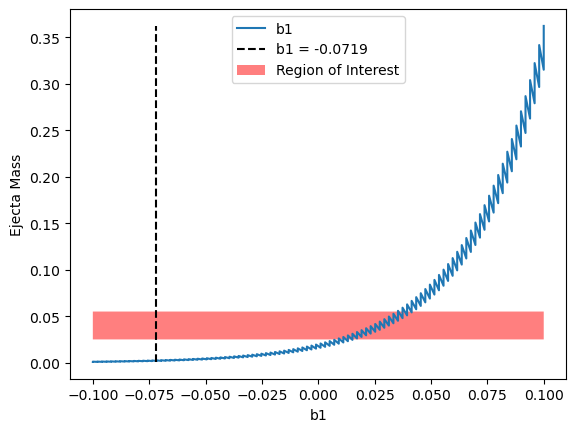

In [24]:
plt.plot(b1_values, ejecta1, label='b1')
plt.xlabel('b1')
plt.ylabel('Ejecta Mass')
plt.legend()
plt.vlines(-0.0719, np.min(ejecta1), np.max(ejecta1), color='black', linestyle='dashed',label='b1 = -0.0719')
ax = plt.gca()
ax.fill_between(b1_values, y1, y2, facecolor='red', alpha=0.5,label = 'Region of Interest')
ax.legend(loc = 'upper center')

plt.savefig('Fig/ejecta_mass_sly_b1.png')


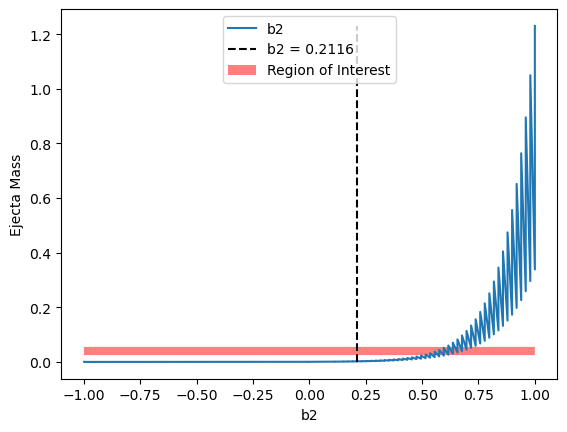

In [25]:
plt.plot(b2_values, ejecta2, label='b2')
plt.xlabel('b2')
plt.ylabel('Ejecta Mass')
plt.vlines(0.2116, np.min(ejecta2), np.max(ejecta2), color='black', linestyle='dashed',label='b2 = 0.2116')
plt.legend()
ax = plt.gca()
ax.fill_between(b2_values, y1, y2, facecolor='red', alpha=0.5,label = 'Region of Interest')
ax.legend(loc = 'upper center')
plt.savefig('Fig/ejecta_mass_sly_b2.png')



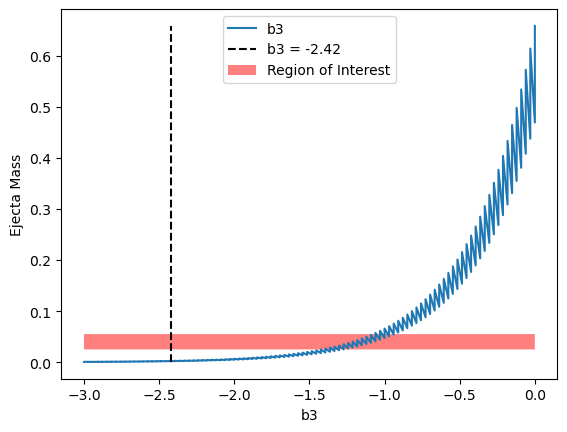

In [26]:
plt.plot(b3_values, ejecta3, label='b3')
plt.xlabel('b3')
plt.ylabel('Ejecta Mass')
plt.vlines(-2.42, np.min(ejecta3), np.max(ejecta3), color='black', linestyle='dashed',label='b3 = -2.42')
plt.legend()
ax = plt.gca()
ax.fill_between(b3_values, y1, y2, facecolor='red', alpha=0.5,label = 'Region of Interest')
ax.legend(loc = 'upper center')
plt.savefig('Fig/ejecta_mass_sly_b3.png')


In [ ]:
R16